# Module Import

In [1]:
import pandas as pd
import numpy as np
import openpyxl

import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# pandas 경고 무시
pd.set_option('mode.chained_assignment',  None)

from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# Data Load

In [2]:
data = pd.read_csv('../data/행정자치부 공공데이터 숙박업 등록현황.csv', encoding = 'cp949')
# 데이터 출처 : 공공데이터포털 / 행정안전부_숙박업 데이터
# https://www.data.go.kr/data/15044968/fileData.do
print(data.shape)
data.head()

(54051, 51)


,번호,개방서비스명,개방서비스아이디,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,...,조건부허가시작일자,조건부허가종료일자,건물소유구분명,세탁기수,여성종사자수,남성종사자수,회수건조수,침대수,다중이용업소여부,Unnamed: 50
0,1,숙박업,03_11_03_P,3620000,3620000-201-2005-00005,20050818,NaN,1,영업/정상,1,...,NaN,NaN,임대,0.0,NaN,NaN,0.0,0.0,N,NaN
1,2,숙박업,03_11_03_P,3620000,3620000-201-2000-00013,20000615,NaN,1,영업/정상,1,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,N,NaN
2,3,숙박업,03_11_03_P,3620000,3620000-214-1985-00002,19851119,NaN,1,영업/정상,1,...,NaN,NaN,자가,0.0,NaN,NaN,0.0,0.0,N,NaN
3,4,숙박업,03_11_03_P,3620000,3620000-201-2000-00014,20000710,NaN,1,영업/정상,1,...,NaN,NaN,자가,0.0,NaN,NaN,0.0,0.0,N,NaN
4,5,숙박업,03_11_03_P,3620000,3620000-201-2002-00007,20020429,NaN,1,영업/정상,1,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,N,NaN


# Data Preprocessing

In [3]:
# 영업중인 숙박시설만 추출
df = data[data['상세영업상태명']=="영업"]

# 필요한 열만 추출 
df = df[['사업장명','업태구분명', '인허가일자']]

# 인허가일자 중 연도만 추출
df['인허가일자'] = df['인허가일자'].apply(lambda x: str(x)[:4])
df['인허가일자'] = df['인허가일자'].astype(int)

# 2022년 데이터 제거
df = df[df['인허가일자']<2022]

df = df.rename(columns={'사업장명':'name', '업태구분명':'type', '인허가일자':'year'})

In [4]:
# 숙박업 유형별 가격 산정 / 예상숙박업소가격*예상평균숙박업소객실수*30일*12개월

def price(x):
    if x == '여관업':
        return 30000*20*30*12
    elif x == '숙박업(생활)':
        return 60000*30*50*12
    elif x == '일반호텔':
        return 80000*50*30*12
    elif x == '여인숙업':
        return 30000*20*30*12
    elif x == '숙박업 기타':
        return 30000*20*30*12
    elif x == '관광호텔':
        return 80000*50*30*12
    else:
        return 150000*100*30*12
    
# 숙박업 유형 변경
def hoteltype(x):
    if x == '숙박업(생활)':
        return '생활형숙박시설'
    else:
        return '일반숙박시설'

In [5]:
df['price'] = df['type'].apply(price)
df['type'] = df['type'].apply(hoteltype)
df.head()

,name,type,year,price
0,야자,일반숙박시설,2005,216000000
1,엔(N)모텔,일반숙박시설,2000,216000000
2,디오앤에스임동,생활형숙박시설,1985,1080000000
3,에로스모텔,일반숙박시설,2000,216000000
4,클라우드인호텔,일반숙박시설,2002,216000000


In [6]:
# 2010년 이후 데이터만 출력

after2010 = df[df['year']>=2010]
df_normal = after2010[after2010['type']=='일반숙박시설']
df_residence = after2010[after2010['type']=='생활형숙박시설']
display(df_normal.head())
display(df_residence.head())

,name,type,year,price
6,게스트 145,일반숙박시설,2017,1440000000
33,파라다이스모텔,일반숙박시설,2011,216000000
40,네모모텔,일반숙박시설,2018,216000000
43,프리마,일반숙박시설,2016,216000000
58,아리랑 민속모텔,일반숙박시설,2010,216000000


,name,type,year,price
330,청춘게스트하우스 호스텔,생활형숙박시설,2017,1080000000
349,부례관광지바이크텔,생활형숙박시설,2017,1080000000
354,대가야왕가마을,생활형숙박시설,2010,1080000000
412,호텔로제니아,생활형숙박시설,2014,1080000000
479,별빛테마마을 펜션동,생활형숙박시설,2018,1080000000


In [7]:
year_list = list(np.arange(2010,2022,1))*2
type_list = ['일반숙박시설']*12+['생활형숙박시설']*12
price_list = list(df_normal.groupby('year')['price'].sum()) + list(df_residence.groupby('year')['price'].sum())
cumsum_list = list(df_normal.groupby('year')['price'].sum().cumsum()) + list(df_residence.groupby('year')['price'].sum().cumsum())

In [8]:
df_price = pd.DataFrame({'year':year_list, 'type':type_list, 'price':price_list, 'cumsum':cumsum_list})

In [9]:
# 증가율
rate_list = [0,]

for i in range(11):
    rate_list.append((df_price['price'][i+1]-df_price['price'][i])/df_price['price'][i])

rate_list.append(0)

for i in range(12,len(df_price)-1):
    rate_list.append((df_price['price'][i+1]-df_price['price'][i])/df_price['price'][i])
    
df_price['rate'] = rate_list;

In [10]:
# 3년 평균 증가율
exp_list = [0,0]

for i in range(10):
    exp_list.append((df_price['rate'][i]+df_price['rate'][i+1]+df_price['rate'][i+2])/3)

exp_list.extend([0,0])

for i in range(12,len(df_price)-2):
    exp_list.append((df_price['rate'][i]+df_price['rate'][i+1]+df_price['rate'][i+2])/3)
    
df_price['expectation_rate'] = exp_list;

In [11]:
x = np.arange(12)
y_normal= list(df_normal.groupby('year')['price'].sum().cumsum())
y_residence = list(df_residence.groupby('year')['price'].sum().cumsum())
lst_normal = pd.DataFrame({'x':x, 'y':y_normal})
lst_residence = pd.DataFrame({'x':x, 'y':y_residence})

- Regression Fitting (Prediction)

In [12]:
# 일반숙박시설 시장규모 2차 회귀식 적합

model_normal = smf.ols("y_normal~x+np.square(x)", data=lst_normal).fit()
model_normal.summary()

C:\Users\zyunhyeok\anaconda3\envs\dl\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               y_normal   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     949.8
Date:                Wed, 16 Feb 2022   Prob (F-statistic):           3.40e-11
Time:                        16:37:06   Log-Likelihood:                -317.94
No. Observations:                  12   AIC:                             641.9
Df Residuals:                       9   BIC:                             643.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5.915e+10   6.63e+10      0.892      0.396   -9.08e+10    2.09e+11
x             2.884e+11    2.8e+10     10.293      0.000    2.25e+11    3.52e+11
np.square(x)  3.476e+09   2.45e+09      1.416      0.190   -2.08e+09    9.03e+09
==============================================================================
Omnibus:                        1.949   Durbin-Watson:                   0.724
Prob(Omnibus):                  0.377   Jarque-Bera (JB):                0.874
Skew:                           0.060   Prob(JB):                        0.646
Kurtosis:                       1.684   Cond. No.                         158.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# 생활형숙박시설 시장규모 2차 회귀식 적합

model_residence = smf.ols("y_residence~x+np.square(x)", data=lst_residence).fit()
model_residence.summary()

C:\Users\zyunhyeok\anaconda3\envs\dl\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            y_residence   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     7101.
Date:                Wed, 16 Feb 2022   Prob (F-statistic):           4.05e-15
Time:                        16:37:06   Log-Likelihood:                -307.18
No. Observations:                  12   AIC:                             620.4
Df Residuals:                       9   BIC:                             621.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     8.639e+10   2.71e+10      3.192      0.011    2.52e+10    1.48e+11
x             1.023e+11   1.14e+10      8.940      0.000    7.64e+10    1.28e+11
np.square(x)  2.323e+10      1e+09     23.188      0.000     2.1e+10    2.55e+10
==============================================================================
Omnibus:                        0.303   Durbin-Watson:                   2.495
Prob(Omnibus):                  0.859   Jarque-Bera (JB):                0.442
Skew:                          -0.226   Prob(JB):                        0.802
Kurtosis:                       2.176   Cond. No.                         158.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# 회귀식을 바탕으로 하여 예측값 계산

def quadratic_normal(x):
    return model_normal.params['np.square(x)']*x**2 + model_normal.params['x']*x + model_normal.params['Intercept']

def quadratic_residence(x):
    return model_residence.params['np.square(x)']*x**2 + model_residence.params['x']*x + model_residence.params['Intercept']

In [15]:
# 2025년까지의 예측값 추가

x = np.arange(2010,2026)

for i in range(12,16):
    y_normal.append(round(quadratic_normal(i)))
    y_residence.append(round(quadratic_residence(i)))

In [16]:
lst_normal = pd.DataFrame({'x':x, 'y':y_normal})
lst_residence = pd.DataFrame({'x':x, 'y':y_residence})

In [17]:
price_normal = list(df_normal.groupby('year')['price'].sum())
price_residence = list(df_residence.groupby('year')['price'].sum())

In [18]:
for i in range(11,15):
    price_normal.append(quadratic_normal(i+1) - y_normal[i])
    price_residence.append(quadratic_residence(i+1) - y_residence[i])

In [19]:
year_list = list(np.arange(2010,2026,1))*2
type_list = ['일반숙박시설']*16+['생활형숙박시설']*16
price_list = list(price_normal) + list(price_residence)
cumsum_list = y_normal+y_residence

In [20]:
df_pred = pd.DataFrame({'year':year_list, 'type':type_list, 'price':price_list, 'cumsum':cumsum_list})

# Data Visualization

In [21]:
parameters = {'axes.labelsize': 25,
          'axes.titlesize': 35,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15}
plt.rcParams.update(parameters)

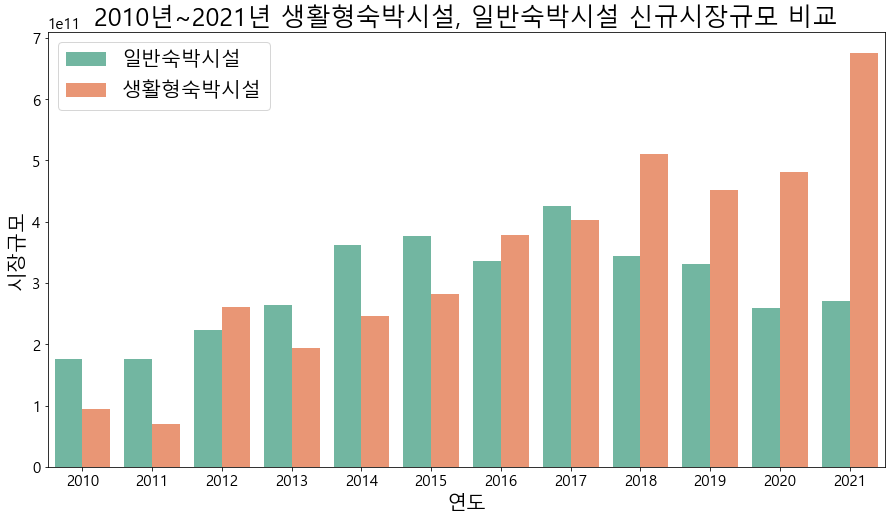

In [22]:
plt.figure(figsize=(15,8))
sns.barplot(data=df_price, x="year", y="price", hue="type", palette='Set2')

plt.title('2010년~2021년 생활형숙박시설, 일반숙박시설 신규시장규모 비교', fontsize=25)
plt.xlabel('연도', fontsize=20)
plt.ylabel('시장규모', fontsize=20)
plt.legend(fontsize=20, loc = 'best')
plt.show()

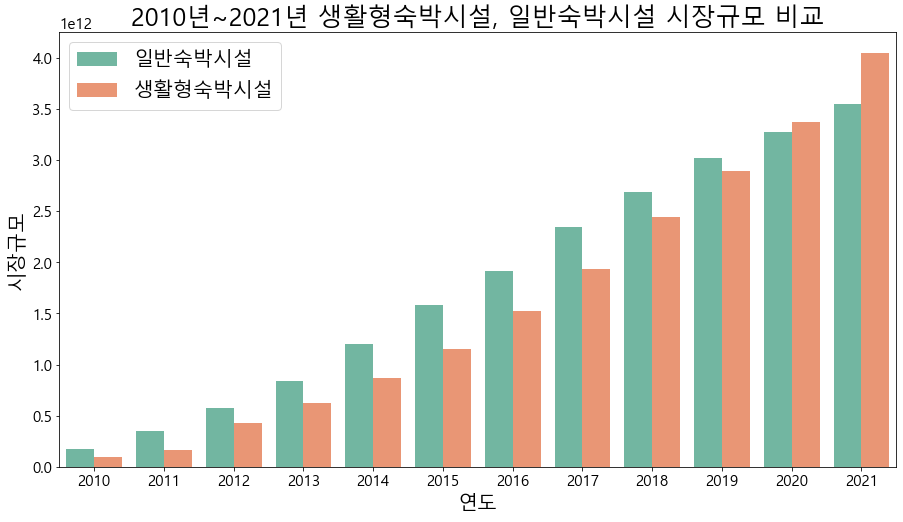

In [23]:
plt.figure(figsize=(15,8))
sns.barplot(data=df_price, x="year", y="cumsum", hue="type", palette='Set2')

plt.title('2010년~2021년 생활형숙박시설, 일반숙박시설 시장규모 비교', fontsize=25)
plt.xlabel('연도', fontsize=20)
plt.ylabel('시장규모', fontsize=20)
plt.legend(fontsize=20, loc = 'best')
plt.show()

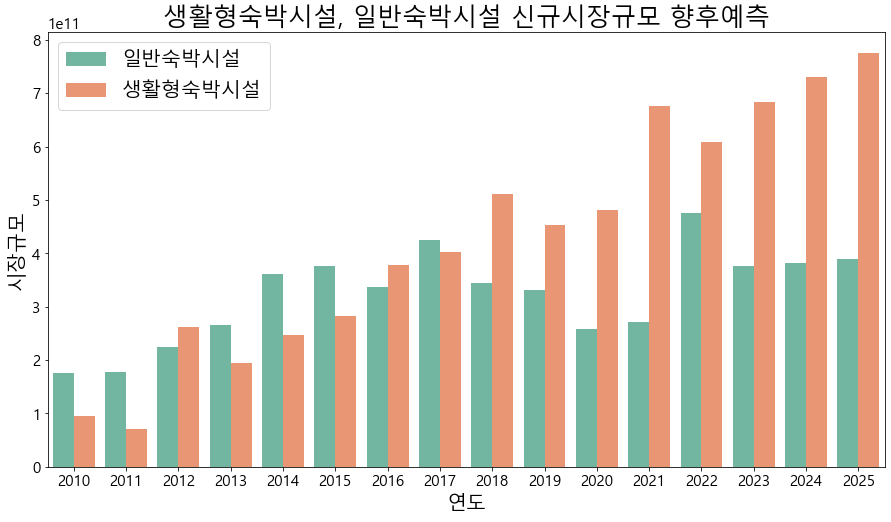

In [24]:
plt.figure(figsize=(15,8))
sns.barplot(data=df_pred, x="year", y="price", hue="type", palette='Set2')

plt.title('생활형숙박시설, 일반숙박시설 신규시장규모 향후예측', fontsize=25)
plt.xlabel('연도', fontsize=20)
plt.ylabel('시장규모', fontsize=20)
plt.legend(fontsize=20, loc = 'best')
plt.show()

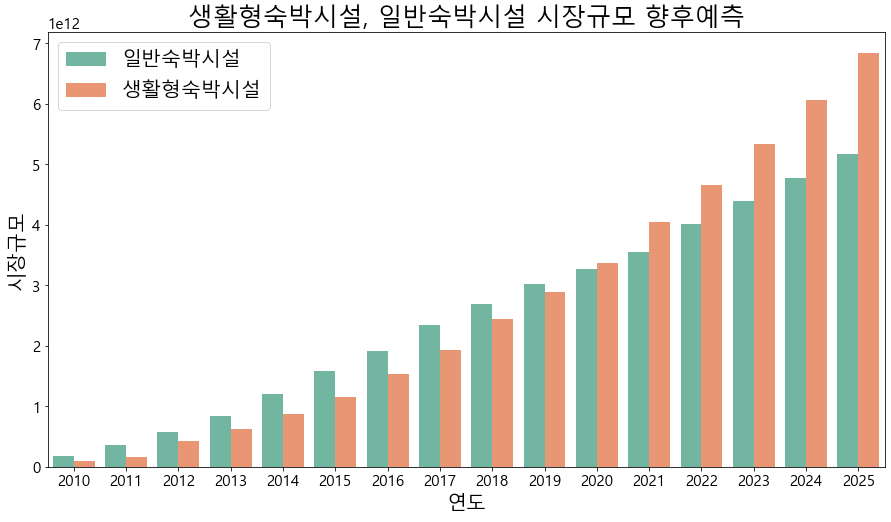

In [25]:
plt.figure(figsize=(15,8))
sns.barplot(data=df_pred, x="year", y="cumsum", hue="type", palette='Set2')

plt.title('생활형숙박시설, 일반숙박시설 시장규모 향후예측', fontsize=25)
plt.xlabel('연도', fontsize=20)
plt.ylabel('시장규모', fontsize=20)
plt.legend(fontsize=20, loc = 'best')
plt.show()